## Import Dependencies

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [36]:
# setting seed
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

## Preparing Dataset

In [61]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):

    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
        # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
        # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [62]:
load_data("AAPL")["df"]

,open,high,low,close,adjclose,volume,ticker
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,AMZN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,AMZN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,AMZN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,AMZN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,AMZN
...,...,...,...,...,...,...,...
2021-01-14,3167.520020,3178.000000,3120.590088,3127.469971,3127.469971,3070900,AMZN
2021-01-15,3123.020020,3142.550049,3095.169922,3104.250000,3104.250000,4244000,AMZN
2021-01-19,3107.000000,3145.000000,3096.000000,3120.760010,3120.760010,3305100,AMZN
2021-01-20,3181.989990,3279.800049,3175.000000,3263.379883,3263.379883,5309800,AMZN


## Create Model

In [44]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

## Training the Model

In [63]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 30
# scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 5
# Amazon stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

## Create the folders

In [64]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

## Load Data and Train

In [65]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/5
74/74 [==============================] - 35s 424ms/step - loss: 0.0017 - mean_absolute_error: 0.0275 - val_loss: 2.4362e-04 - val_mean_absolute_error: 0.0108

Epoch 00001: val_loss improved from inf to 0.00024, saving model to results/2021-01-21_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-30-layers-2-units-256.h5
Epoch 2/5
74/74 [==============================] - 33s 451ms/step - loss: 6.2917e-04 - mean_absolute_error: 0.0167 - val_loss: 4.0375e-04 - val_mean_absolute_error: 0.0148

Epoch 00002: val_loss did not improve from 0.00024
Epoch 3/5
74/74 [==============================] - 36s 482ms/step - loss: 6.0750e-04 - mean_absolute_error: 0.0172 - val_loss: 9.4589e-04 - val_mean_absolute_error: 0.0226

Epoch 00003: val_loss did not improve from 0.00024
Epoch 4/5
74/74 [==============================] - 35s 474ms/step - loss: 7.1205e-04 - mean_absolute_error: 0.0199 - val_loss: 2.3725e-04 - val_mean_absolute_error: 0.0109

Epoch 00004: val_loss improved from 0.00024 

## Plot Graph

In [ ]:
!tensorboard --logdir="logs"

## Testing the Model

In [66]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

## Predictions

In [67]:
def get_final_df(model, data):
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [68]:
get_final_df(model, data)

,open,high,low,close,adjclose,volume,ticker,adjclose_30,true_adjclose_30,buy_profit,sell_profit
1997-08-11,2.291667,2.333333,2.250000,2.328125,2.328125,1239600,AMZN,-0.228711,4.625000,-2.556836,0.000000
1997-08-13,2.229167,2.229167,2.166667,2.197917,2.197917,590400,AMZN,-0.770412,4.078125,-2.968328,0.000000
1997-08-15,2.135417,2.156250,1.937500,2.114583,2.114583,1597200,AMZN,-1.082906,4.041667,-3.197490,0.000000
1997-08-19,2.093750,2.208333,2.052083,2.166667,2.166667,1003200,AMZN,-1.166287,4.020833,-3.332954,0.000000
1997-08-21,2.135417,2.171875,2.072917,2.114583,2.114583,624000,AMZN,-1.315762,4.015625,-3.430345,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,3116.699951,3139.750000,3065.459961,3098.389893,3098.389893,4708900,AMZN,3231.005615,3162.159912,132.615723,0.000000
2020-11-25,3141.870117,3198.000000,3140.260010,3185.070068,3185.070068,3790400,AMZN,3232.160645,3114.209961,0.000000,-47.090576
2020-11-30,3208.479980,3228.389893,3125.550049,3168.040039,3168.040039,4063900,AMZN,3255.351074,3165.889893,0.000000,-87.311035
2020-12-01,3188.500000,3248.949951,3157.179932,3220.080078,3220.080078,4544400,AMZN,3268.103760,3127.469971,0.000000,-48.023682


## Predict future price

In [69]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

## Evaluating the model

In [70]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

## Loss and Mean calculation

In [71]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

## Test Dataframe

In [72]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)
final_df

,open,high,low,close,adjclose,volume,ticker,adjclose_30,true_adjclose_30,buy_profit,sell_profit
1997-08-11,2.291667,2.333333,2.250000,2.328125,2.328125,1239600,AMZN,2133.982422,2421.860107,2131.654297,0.000000
1997-08-13,2.229167,2.229167,2.166667,2.197917,2.197917,590400,AMZN,20.431917,15.530000,18.234000,0.000000
1997-08-15,2.135417,2.156250,1.937500,2.114583,2.114583,1597200,AMZN,44.428955,39.099998,42.314372,0.000000
1997-08-19,2.093750,2.208333,2.052083,2.166667,2.166667,1003200,AMZN,108.816673,56.468750,106.650007,0.000000
1997-08-21,2.135417,2.171875,2.072917,2.114583,2.114583,624000,AMZN,588.119202,675.340027,586.004618,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,3116.699951,3139.750000,3065.459961,3098.389893,3098.389893,4708900,AMZN,549.027649,570.760010,0.000000,2549.362244
2020-11-25,3141.870117,3198.000000,3140.260010,3185.070068,3185.070068,3790400,AMZN,105.164742,55.781250,0.000000,3079.905327
2020-11-30,3208.479980,3228.389893,3125.550049,3168.040039,3168.040039,4063900,AMZN,246.803558,221.309998,0.000000,2921.236481
2020-12-01,3188.500000,3248.949951,3157.179932,3220.080078,3220.080078,4544400,AMZN,88.023491,49.580002,0.000000,3132.056587


## Get future price

In [73]:
# predict the future price
future_price = predict(model, data)
future_price

3279.1948

## Count of Positive Profit

In [74]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

## Print metrics

In [75]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 30 days is 3279.19$
huber_loss loss: 0.00022355937107931823
Mean Absolute Error: 36.982528127581084
Accuracy score: 0.9583687340696686
Total buy profit: 355823.8133409023
Total sell profit: 322529.66209991276
Total profit: 678353.4754408151
Profit per trade: 576.3411006294095


## Plot actual prediction

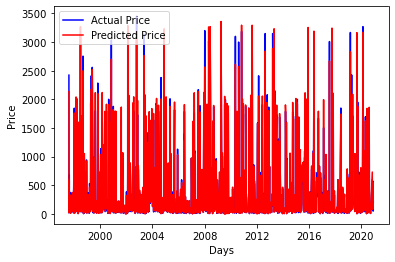

In [76]:
# plot true/pred prices graph
plot_graph(final_df)

In [60]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                  open        high         low       close    adjclose  \
2020-08-18  114.352501  116.000000  114.007500  115.562500  115.363472   
2020-08-21  119.262497  124.867500  119.250000  124.370003  124.155800   
2020-09-02  137.589996  137.979996  127.000000  131.399994  131.173691   
2020-09-16  115.230003  116.000000  112.040001  112.129997  111.936882   
2020-09-22  112.680000  112.860001  109.160004  111.809998  111.617432   
2020-09-29  114.550003  115.309998  113.570000  114.089996  113.893501   
2020-10-01  117.639999  117.720001  115.830002  116.790001  116.588860   
2020-10-06  115.699997  116.120003  112.250000  113.160004  112.965111   
2020-10-29  112.370003  116.930000  112.199997  115.320000  115.121384   
2020-11-11  117.190002  119.629997  116.440002  119.489998  119.489998   

                 volume ticker  adjclose_30  true_adjclose_30  buy_profit  \
2020-08-18  105633600.0   AAPL     0.090442          0.194702         0.0   
2020-08-21  338054800.0   AAPL 